In [1]:
import numpy as np
from methods import Hexagon, HexagonalGCs, rotation_matrix
import torch
from tqdm import tqdm

import matplotlib.pyplot as plt
import scipy.stats

from models import PlaceCells

In [2]:
class PlaceCells(HexagonalGCs):
    """
    torch model for learning optimal place cell phases
    """

    def __init__(self, ncells=3, f = 1, init_rot = 0, sig=1, scale = None, dtype=torch.float32, **kwargs):
        super(PlaceCells, self).__init__(ncells, f, init_rot, **kwargs)
        
        self.sig = sig # place cell tuning width 
        # conformal scaling factor.
        if scale is None:
            self.scale = torch.nn.Parameter(torch.ones(1,dtype = torch.float32))
        else:
            self.scale = scale
        

    def forward(self, r, rectify=False):
        """
        Parameters:
            r (nsamples,2): spatial samples
        Returns:
            activity (nsamples,ncells): activity of all cells on spatial samples
        """
        activity = torch.exp(-torch.sum((r[:, None] - self.phases[None])**2/(2*self.sig**2), dim = -1))
        return activity

    def jacobian(self, r):
        """
        Jacobian of the forward function

        Parameters:
            r (nsamples,2): spatial samples
        Returns:
            J (nsamples,ncells,2): jacobian of the forward function
        """
        p = self(r)
        J = -1/self.sig**2*(r[:,None] - self.phases[None])*p[...,None]   
        return J

    def metric(self, r):
        J = self.jacobian(r)
        return torch.transpose(J, -2, -1) @ J
    
    def loss_fn(self, r):
        """
        Scaled conformal Isometry loss
        """
        g = self.metric(r)        
        diag_loss = (g[:,0,0] - self.scale*100)**2 +  (g[:,1,1] - self.scale*100)**2 
        cross_loss = 2*g[:,0ww,1]**2
        return torch.mean(diag_loss+cross_loss)
    

In [3]:
pc_ensemble = PlaceCells(ncells = 100, scale = 1, sig = 0.1)

In [4]:
r = pc_ensemble.unit_cell.sample(1000).astype("float32")

In [5]:
p = pc_ensemble(torch.tensor(r))

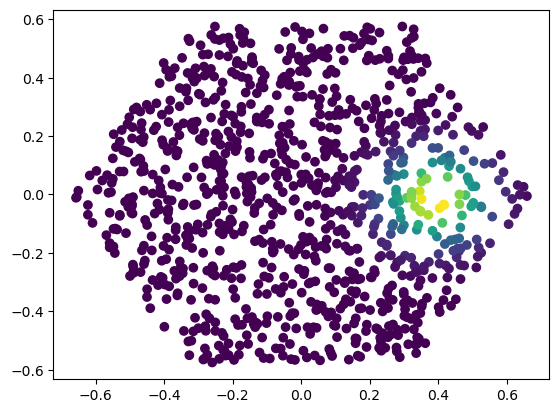

In [6]:
plt.scatter(r[:,0], r[:,1], c = p[:,0].detach().numpy())

In [7]:
J_p = pc_ensemble.jacobian(torch.tensor(r)) # plot jacobian

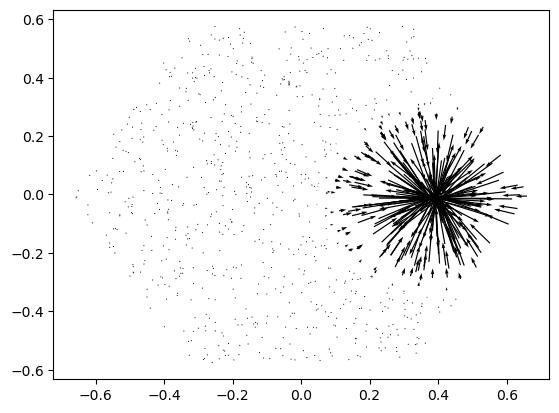

In [8]:
plt.quiver(r[:,0], r[:,1], J_p[:,0,0].detach().numpy(), J_p[:,0,1].detach().numpy())

In [9]:
steps = 10000
progress = tqdm(range(steps),leave = False)

trained_models = []
losses = []

cell_counts = [10, 50, 100, 200, 300, 1000]
#cell_counts = range(140, 160, 3)

learned_scale = []

nn = 50
a = 0.5
b = a
xx, yy = np.meshgrid(np.linspace(-a, a, nn), np.linspace(-a, b, nn))
u = np.stack((xx.ravel(), yy.ravel()), axis = -1).astype("float32")

for ncells in cell_counts:
    model = PlaceCells(ncells = ncells, sig = 0.1)
    loss = []
    for i in range(steps):
        r = np.random.uniform(-a, a, (256, 2)).astype("float32")
        loss_val = model.train_step(torch.tensor(r))
        loss.append(loss_val)
        progress.set_description(str(loss_val))
        progress.update()
    
    g = torch.mean(model.metric(torch.tensor(u)), dim = 0)
    learned_scale.append([g[0,0].item(), g[1,1].item()])
    losses.append(loss)
    trained_models.append(model)

14962.3623046875:  30%|█████▎            | 2970/10000 [00:02<00:06, 1054.15it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

14694.623046875:  66%|████████████▌      | 6635/10000 [00:06<00:03, 1049.10it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

2909.861328125: : 10383it [00:10, 825.56it/s]                                   IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashin

In [10]:
[torch.save(model, f"./saved-models/{cell_count}_place_cells") for cell_count, model in zip(cell_counts, trained_models)];

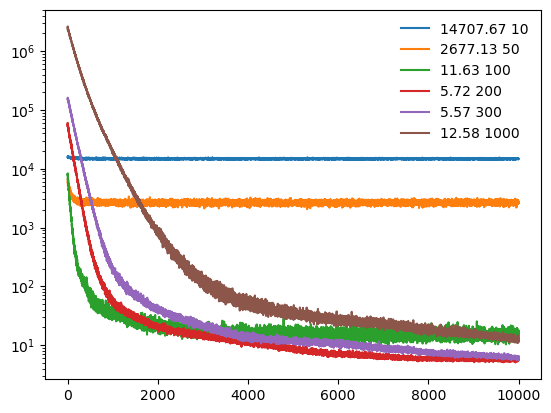

In [11]:
for cells, loss in zip(cell_counts, losses):
    plt.semilogy(loss, label = f"{loss[-1]:.2f} {cells}");
plt.legend(frameon = False)

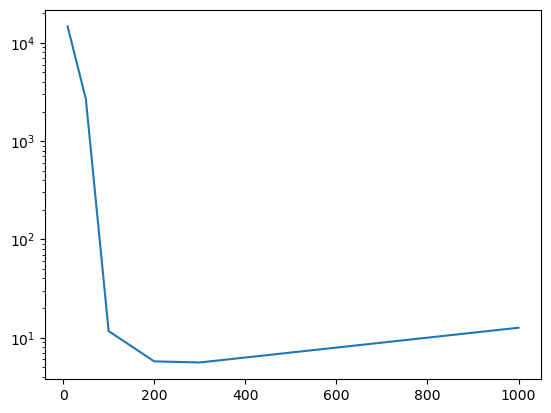

In [12]:
z = [loss[-1] for loss in losses]
plt.semilogy(cell_counts, z)
#plt.title(f"{np.amin(z)} {scales[np.argmin(z)]}")

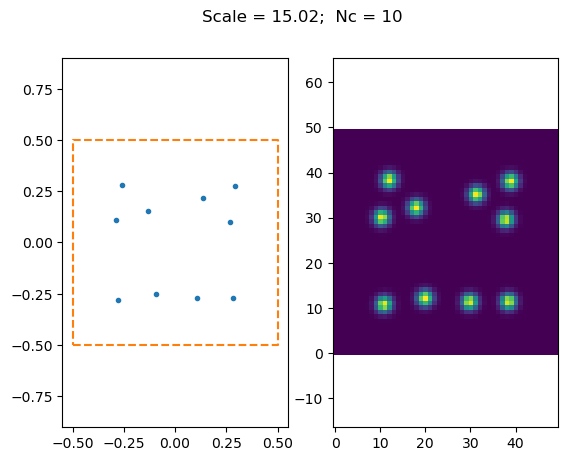

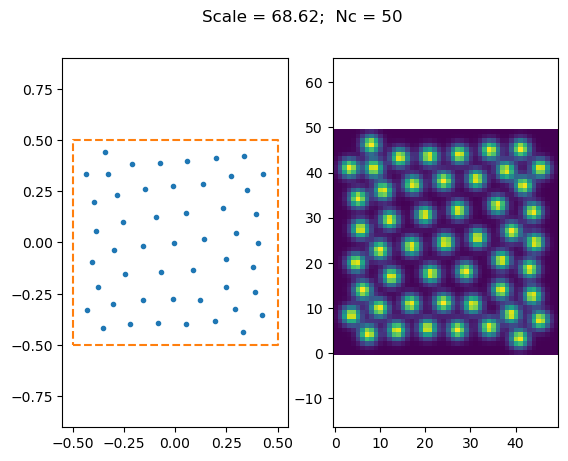

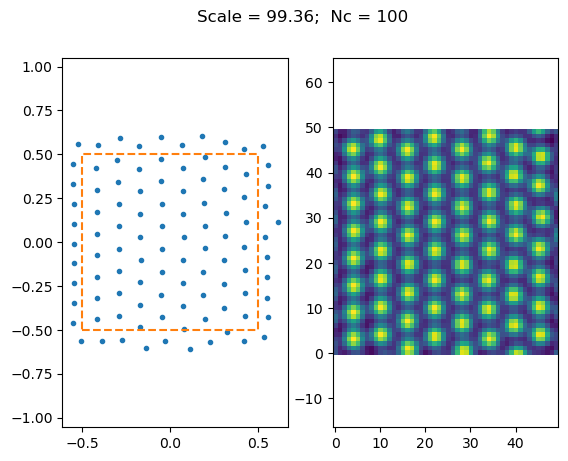

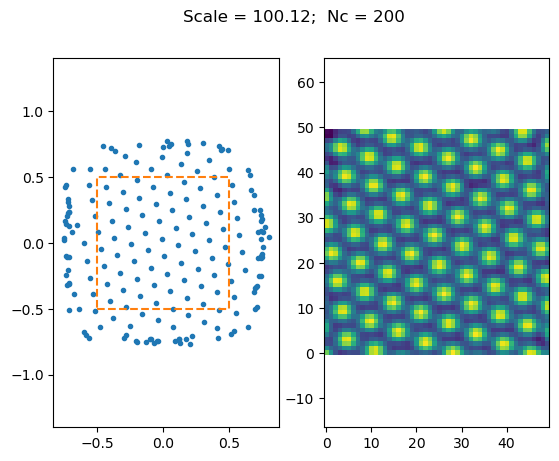

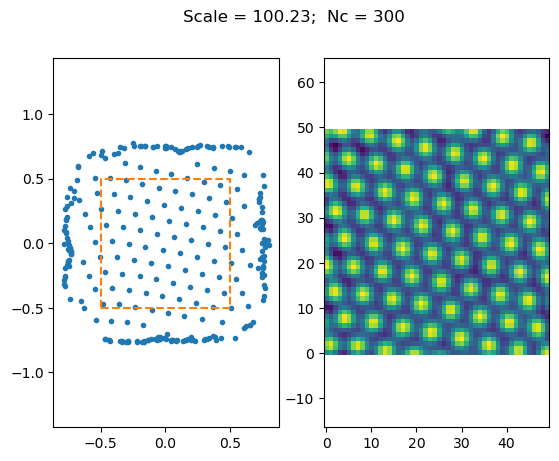

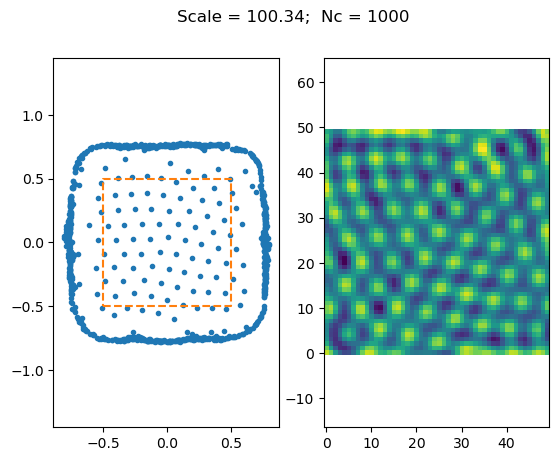

In [13]:
# KDE of phase distribution after training

for i, (scale, model) in enumerate(zip(learned_scale, trained_models)):
    phi = model.phases.detach().numpy()
    kde = scipy.stats.gaussian_kde(np.array(phi).T, 0.1)
    eval_kde = kde(np.array(u).T)
    fig, ax = plt.subplots(1, 2)
    ax[1].imshow(eval_kde.reshape(nn, nn), origin = "lower")
    ax[0].plot(*model.phases.detach().numpy().T, ".");
    
    # plot sample region!
    ax[0].plot([-a, a, a, -a, -a],  [-a, -a, a, a, -a] , "--")
    plt.suptitle(f"Scale = {scale[0]:.2f};  Nc = {cell_counts[i]}")
    ax[0].axis("equal")
    ax[1].axis("equal")
    plt.show()